<a href="https://colab.research.google.com/github/vinitakawale/TSAnalysis/blob/main/ts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
!pip install dtaidistance

In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from plotly.subplots import make_subplots
import plotly as py
import plotly.graph_objects as go
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtw_viz
from sklearn.preprocessing import MinMaxScaler



In [55]:
def make_plots(df):
  fig = make_subplots(rows=2, cols=1)

  fig.append_trace(go.Scatter(
   x=df['timestamp'],
   y=df['baseline'],
), row=1, col=1)

  fig.append_trace(go.Scatter(
    x=df['timestamp'],
    y=df['candidate'],
), row=2, col=1)

  fig.update_layout(height=450, width=716, title_text="Baseline and Candidate")
  fig.show()

In [5]:
def make_plots_corre(df, correlation):
  fig = make_subplots(rows=1, cols=1, subplot_titles=[f" Correlation - {correlation} "])

  fig.append_trace(go.Scatter(
   x=df["baseline"],
   y=df['candidate'],
   mode="markers", line=dict(color="black")
), row=1, col=1)

  fig.update_layout(height=450, width=716, title_text="Baseline and Candidate")
  fig.show()

In [6]:
def make_ts_grid(baseline, candidate, common_x, num_rows, num_cols, plot_mode="lines", sub_titles=None, add_orig=True):
    if sub_titles is None:
        sub_titles = 'no subtitle'

    fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=sub_titles)

    # ts_tup = tuple(ts_dict.items())

    k = 0
    for i in range(num_rows):
        for j in range(num_cols):
            if add_orig is True:
                fig.add_scatter(x=common_x, y=baseline, row=i+1, col=j+1, mode=plot_mode, line=dict(color="blue"))
            if k > 0:
                fig.add_scatter(x=common_x, y=candidate, row=i+1, col=j+1, mode=plot_mode, line=dict(color="grey"), fill='tonexty')
            k += 1

    fig.update_layout(showlegend=False)
    fig.show()

In [24]:
def get_data(category):
  f = open('darkCanaryLogs.json')
  data = json.load(f)

  if category == "cpu_utilization":
    baseline = data["analysis"]["performance"]["CPU_Utilization"]["debug"]["baseline"]
    candidate = data["analysis"]["performance"]["CPU_Utilization"]["debug"]["candidate"]
    return baseline, candidate
  elif category == "latency":
    baseline = data["analysis"]["performance"]["P999_Latency"]["debug"]["baseline"]
    candidate = data["analysis"]["performance"]["P999_Latency"]["debug"]["candidate"]
    return baseline, candidate


In [139]:
baseline, candidate = get_data("latency")

df_baseline = pd.json_normalize(baseline['data'])
df_candidate = pd.json_normalize(candidate['data'])

df_baseline.columns =["value", "timestamp"]
df_baseline = df_baseline[['timestamp', 'value']]
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'], unit='ms' )

df_baseline['value'] = pd.to_numeric(df_baseline['value'])

df_candidate.columns =["value", "timestamp"]
df_candidate = df_candidate[['timestamp', 'value']]
df_candidate['timestamp'] = pd.to_datetime(df_candidate['timestamp'], unit='ms' )

df_candidate['value'] = pd.to_numeric(df_candidate['value'])

In [140]:
df = pd.DataFrame({
    'timestamp': df_baseline['timestamp'],
    'baseline': df_baseline['value'],
    'candidate': df_candidate['value']
})
# df.set_index('timestamp', inplace=True)
make_plots(df)

In [141]:
df_baseline_mean = df['baseline'].mean()
df_candidate_mean = df['candidate'].mean()
df_baseline_std = df['baseline'].std()
df_candidate_std = df['candidate'].std()

print("mean - baseline - candidate", df_baseline_mean, df_candidate_mean )
print("std - baseline - candidate", df_baseline_std, df_candidate_std)


mean - baseline - candidate 24.11749627976191 20.212404447153077
std - baseline - candidate 0.10070322340823465 5.125202481191196


# Scaling


---




*   Scaling is the process of subtracting the mean of the time series
from each value and then dividing the result by the standard deviation of the series.

*  This is the same transformation that is applied to the data when using the z-score normalization.

*  You can find it named time series normalization, scaling, or standardization.


---






In [142]:
df_scaled = df.copy()
# df_scaled['baseline'] = (df_scaled['baseline'] - df_scaled['baseline'].mean()) / df_scaled['baseline'].std()
# df_scaled['candidate'] = (df_scaled['candidate'] - df_scaled['candidate'].mean()) / df_scaled['candidate'].std()

scaler = MinMaxScaler()
values_baseline = df_scaled['baseline'].values.reshape(-1,1)
values_candidate = df_scaled['candidate'].values.reshape(-1,1)
scaler.fit(values_baseline)
df_scaled['baseline'] = scaler.transform(values_baseline)
df_scaled['candidate'] = scaler.transform(values_candidate)
make_plots(df_scaled)

# Detrending


---


*   Detrending is the process of removing any trend from the time series.

*  If we want to measure the similarity of the underlying patterns, not the trend, we can perform detrending using scipy.signal.detrend.


---



In [36]:
from scipy.signal import detrend

df_detrended = df_scaled.copy()
df_detrended['baseline'] = detrend(df_detrended['baseline'])
df_detrended['candidate'] = detrend(df_detrended['candidate'])

make_plots(df_detrended)


# Smoothing


---


Smoothing is the process of removing noise from the time series.

It can be as simple as taking a moving average of the data.

smoothed = detrended.rolling(5).mean().dropna()
Smoothing with a moving average comes from the assumption that the average of the data is a better representation of the underlying pattern than the individual data points.

This code will calculate a rolling average of the data using a window size of 5. You can try different window sizes to see how it affects the results.

I dropped the first 3 rows because they contain NaN values.


---



In [113]:
df_smoothed = df_scaled.copy()
df_smoothed['baseline'] = df_smoothed['baseline'].rolling(5).mean()
df_smoothed['candidate'] = df_smoothed['candidate'].rolling(5).mean()
df_smoothed = df_smoothed.dropna()

make_plots(df_smoothed)

In [134]:
df_smoothed_baseline_mean = df_smoothed['baseline'].mean()
df_smoothed_candidate_mean = df_smoothed['candidate'].mean()
df_smoothed_baseline_std = df_smoothed['baseline'].std()
df_smoothed_candidate_std = df_smoothed['candidate'].std()

print("mean - baseline - candidate", df_smoothed_baseline_mean, df_smoothed_candidate_mean )
print("std - baseline - candidate", df_smoothed_baseline_std, df_smoothed_candidate_std)


mean - baseline - candidate 0.09156590852588882 0.19391331215690213
std - baseline - candidate 0.40511285637185473 0.5474836533630152


In [135]:
import plotly.express as px
# df = px.data.tips()
df_b = pd.DataFrame({"type": "baseline", "values": df_smoothed['baseline']})
df_c = pd.DataFrame({"type": "candidate", "values": df_smoothed['candidate']})
df = pd.concat([df_b, df_c])
df.reset_index(drop=True, inplace=True)
fig = px.box(df, x="type", y="values", points="all", color="type")
fig.show()


In [63]:
print(df)

                    timestamp   baseline  candidate
0  1970-01-20 16:53:19.047888  24.037857   9.987126
1  1970-01-20 16:53:19.107888  24.245000   9.987444
2  1970-01-20 16:53:19.167888  24.152500   9.987650
3  1970-01-20 16:53:19.227888  24.241667  21.587500
4  1970-01-20 16:53:19.287888  24.148750  21.595000
5  1970-01-20 16:53:19.347888  24.154375  21.617500
6  1970-01-20 16:53:19.407888  24.161875  21.632500
7  1970-01-20 16:53:19.467888  24.154375  21.632500
8  1970-01-20 16:53:19.527888  24.148750  22.725000
9  1970-01-20 16:53:19.587888  23.875000  22.745000
10 1970-01-20 16:53:19.647888  24.158125  23.316250
11 1970-01-20 16:53:19.707888  24.256667  23.323750
12 1970-01-20 16:53:19.767888  24.035714  23.320000
13 1970-01-20 16:53:19.827888  24.035714  23.312500
14 1970-01-20 16:53:19.887888  24.037857  23.316250
15 1970-01-20 16:53:19.947888  24.035714  23.312500


In [144]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(
     y=df_smoothed['baseline'].values,
    name='Baseline',
    marker_color='darkblue',
    boxmean='sd' # represent mean and standard deviation
))
fig.add_trace(go.Box(
    y=df_smoothed['candidate'].values,
    name='Candidate',
    marker_color='darkred',
    boxmean='sd' # represent mean and standard deviation
))

fig.show()

# Simple Distances For Time Series Similarity


---



After preprocessing the data, we can use simple distance measures to measure the similarity between two time series.

Pearson Correlation
Pearson correlation is a measure of the linear correlation between two time series.

It was used as an official metric by two financial forecasting competitions on Kaggle: the G-Research Crypto Forecasting and the Ubiquant Market Prediction.

We can calculate the Pearson correlation coefficient directly in pandas with df.corr.




---



In [145]:
correlation = df_smoothed.corr()
correlation

<ipython-input-145-15e550f953e9>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,baseline,candidate
baseline,1.000000,-0.753271
candidate,-0.753271,1.000000


This function gives us the correlation between all pairs of time series in an organized table, which is very convenient.

Pearson correlation varies between -1 and 1. -1 means the time series are perfectly negatively correlated (one goes up when the other goes down), 1 means the time series are perfectly positively correlated (one goes up when the other goes up), and 0 means the time series are not correlated at all.

Anything in between means they are correlated (the direction depends on the signal), but not perfectly.

For example, the correlation between Baseline and Candidate is 0.533, which means that candidate value tends to go up when baseline values go up and vice versa

But be careful! This is not a measure of causation. It only means that this is what happened in the historical data.

In [146]:
# sub_titles_mape_ed = [f"""Baseline and Candidate - Correlation={correlation}"""]

#                       # sub_titles_mape_ed = [f"""{k} - Correlation={calc_pearons_corr(ts_dict["Original"], ts_dict[k]):.2f}"""
#                       # for k in ts_dict.keys()]

# make_ts_grid_corr(candidate, baseline, 1, 1, sub_titles=sub_titles_mape_ed)
make_plots_corre(df_smoothed, correlation)

# Euclidean Distance


---


The Euclidean distance is a widely used technique to measure the similarity between time series.

It is a simple and intuitive measure that calculates the distance between two time series as the straight-line distance between their corresponding points.

We can easily calculate it with the euclidean_distances function from scikit-learn.


---



In [147]:
# from sklearn.metrics.pairwise import euclidean_distances

# df_smoothed['timestamp'] = pd.to_datetime(df_smoothed['timestamp'])
# df_smoothed['timestamp'] = df_smoothed['timestamp'].astype(int)

# euc_dist = euclidean_distances(df_smoothed.T)
# euc_dist
# # pd.DataFrame(euc_dist, index='timestamp', columns=['baseline', 'candidate'])


def euclidean_dist(y_orig, y_ref):
    return np.sqrt(np.sum((y_orig - y_ref) ** 2))


def mape(y_orig, y_ref):
    return np.mean(np.abs(y_orig - y_ref) / y_orig)


def smape(y_orig, y_ref):
    return np.mean(np.abs(y_orig - y_ref) / ((y_orig + y_ref) / 2))

In [148]:
baseline = df_smoothed['baseline'].values
candidate = df_smoothed['candidate'].values
X = pd.to_datetime(df_smoothed['timestamp'])


sub_titles_mape_ed = [f"""{k} -  Mape={mape(baseline, candidate):.2f}, Euclidean Distance={euclidean_dist(baseline, candidate):.2f}, Smape={smape(baseline, candidate):.2f}"""
                      for k in ['baseline', 'candidate']]

make_ts_grid(baseline, candidate, X, 2, 1, sub_titles=sub_titles_mape_ed)

# Dynamic Time Warping


---



Dynamic Time Warping (DTW) is a more advanced technique for measuring the similarity of time series.

DTW can handle time series that are not aligned and also series with different lengths, which happens a lot in real-world data.

In this dataset, some countries have been producing rice for a long time, and others have only started recently, although our selected countries have full data.

DTW works by warping the time axis of one time series to match the time axis of the other time series.

This technique was very successful in the Driver Telematics Analysis competition, where the goal was to identify drivers by looking at their driving behavior.

The main drawback of DTW is that it is computationally expensive. It can take a long time to calculate the distance between two time series, which can be a problem if you have many comparisons to make.

Anyway, the DTAIDistance library implemented a fast version of DTW in C that we can use in Python.


---



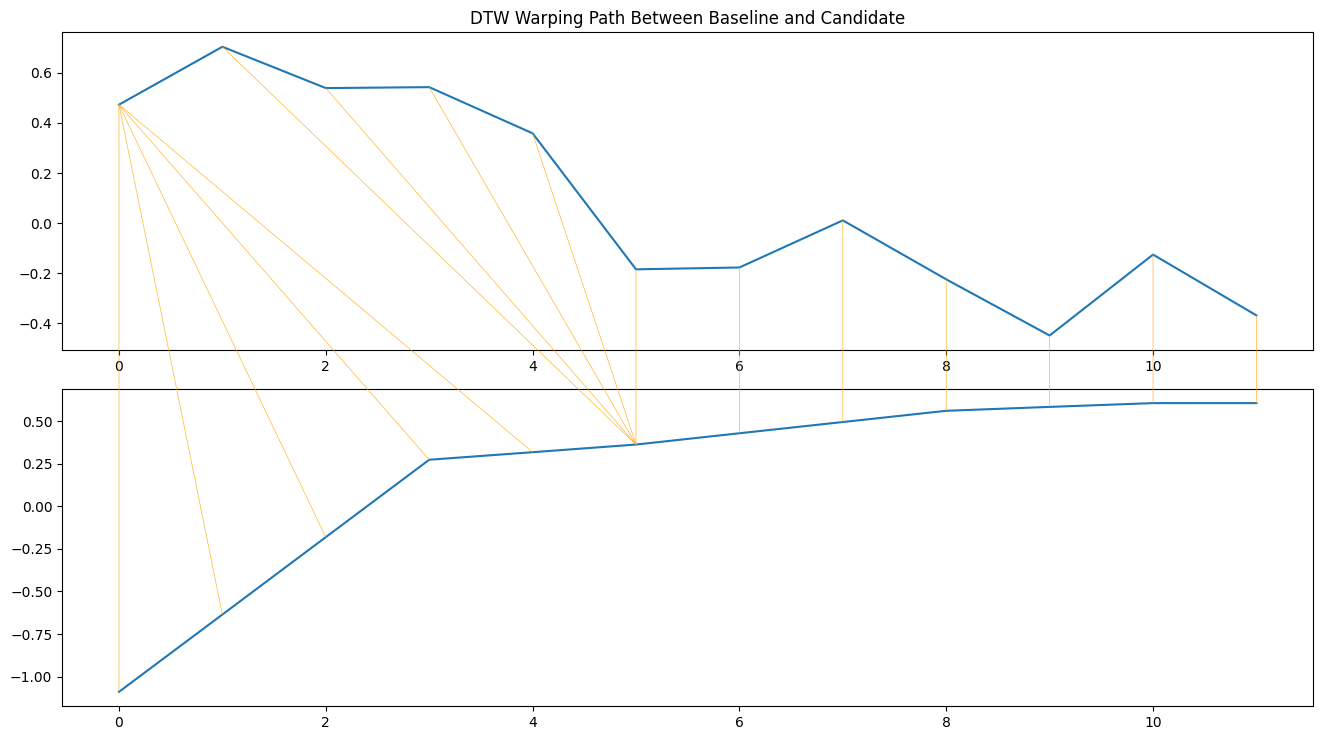

In [149]:
from dtaidistance import dtw_visualisation as dtwvis

fig, ax = plt.subplots(2,1,figsize=(1280/96, 720/96))
path = dtw.warping_path(df_smoothed['baseline'].values, df_smoothed['candidate'].values)
dtwvis.plot_warping(df_smoothed['baseline'].values, df_smoothed['candidate'].values, path,
                    fig=fig, axs=ax)
ax[0].set_title('DTW Warping Path Between Baseline and Candidate')
fig.tight_layout()

(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

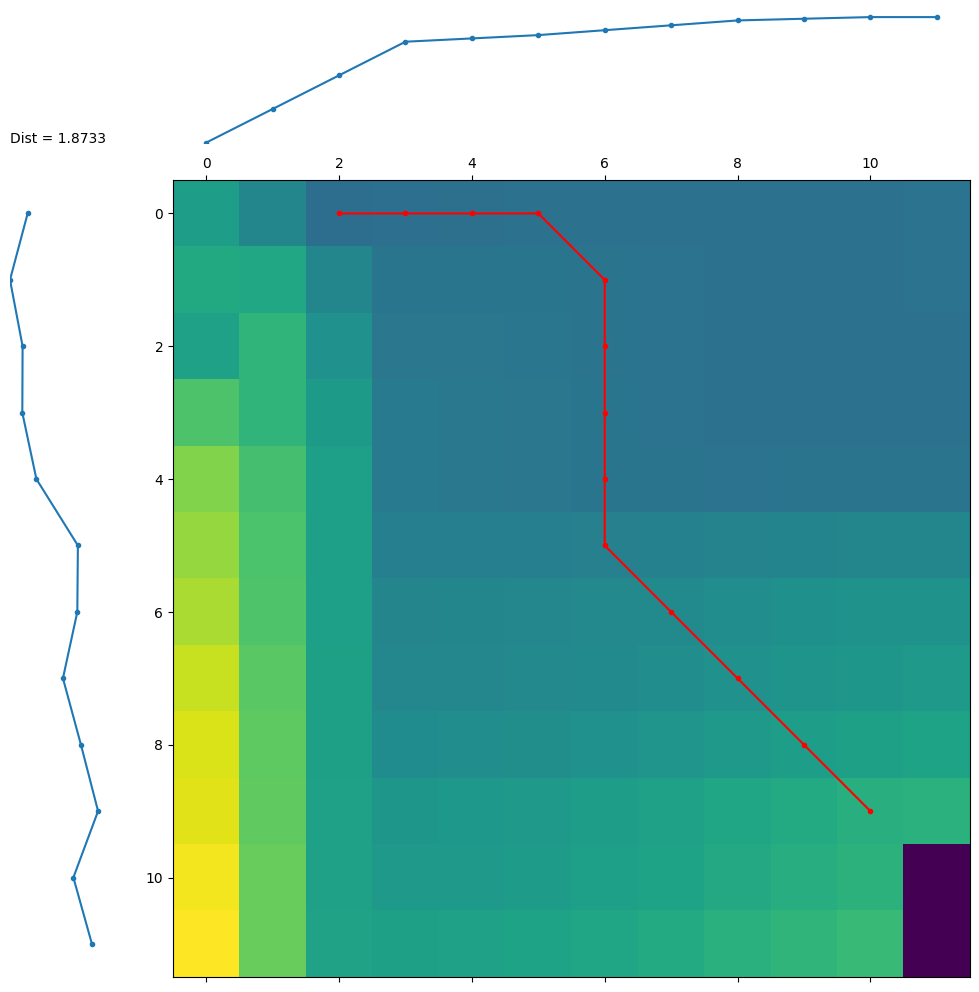

In [150]:
baseline = df_smoothed["baseline"].values
candidate = df_smoothed["candidate"].values


d, paths = dtw.warping_paths(baseline, candidate, window=25, psi=2)
best_path = dtw.best_path(paths)
dtw_viz.plot_warpingpaths(baseline, candidate, paths, best_path)

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

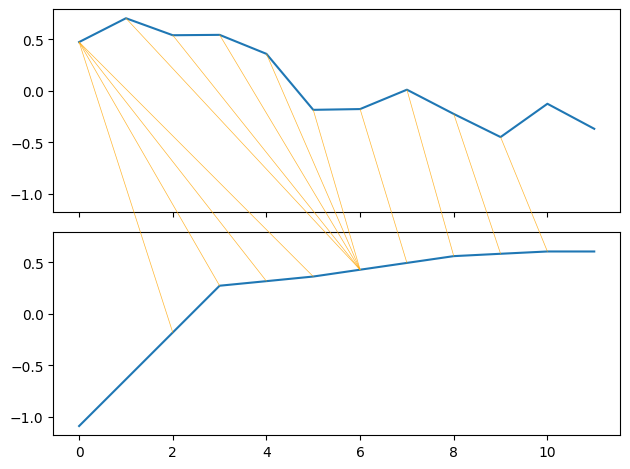

In [151]:
dtw_viz.plot_warping(baseline, candidate, best_path)